In [1]:
%pip install geopandas rasterio matplotlib scikit-learn pandas pyimpute xgboost lightgbm


Note: you may need to restart the kernel to use updated packages.


# Species Distribution Data Loading

In [3]:
import os 
if not os.path.exists("inputs"):
    os.mkdir("inputs")
if not os.path.exists("outputs"):
    os.mkdir("outputs")

In [ ]:
import geopandas as gpd
import shutil
import glob

for f in sorted(glob.glob('data/shp/*')):
    shutil.copy(f,'inputs/')

pa = gpd.GeoDataFrame.from_file("inputs/CardellinaPusilla.shp")
pa.sample(5) # GeoDataFrame for the species

,CLASS,geometry
5005,0.0,POINT (-118.72917 36.72917)
2642,1.0,POINT (-120.14310 38.91211)
1252,1.0,POINT (-123.67785 40.87186)
4126,0.0,POINT (-119.18750 37.22917)
2267,0.0,POINT (-114.93750 34.93750)


In [ ]:
print("number of duplicates: ", pa.duplicated(subset='geometry', keep='first').sum())
print("number of NA's: ", pa['geometry'].isna().sum())
print("Coordinate reference system is: {}".format(pa.crs))
print("{} observations with {} columns".format(*pa.shape))

number of duplicates:  0
number of NA's:  0
Coordinate reference system is: EPSG:4326
6000 observations with 2 columns


We can map the species presences (`pa==1`).

<Axes: >

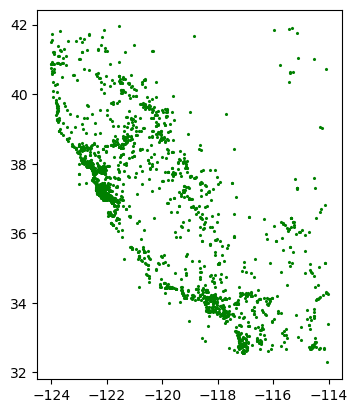

In [ ]:
pa[pa.CLASS == 1].plot(marker='*', color='green', markersize=2)

And we can map the background points (`pa == 0`).

<Axes: >

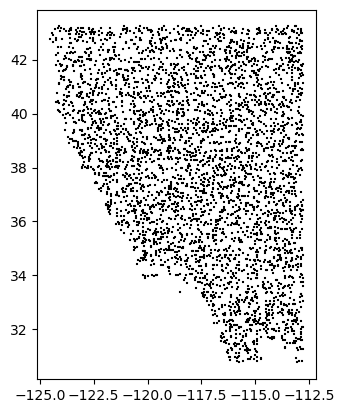

In [ ]:
pa[pa.CLASS == 0].plot(marker='+', color='black', markersize=1)

# Climate Data Loading and Preprocessing

Load Climate Data

In [ ]:
# grab climate features - cropped to joshua tree study area
for f in sorted(glob.glob('data/bclim/bclim*.asc')):
    shutil.copy(f,'inputs/')
raster_features = sorted(glob.glob(
    'inputs/bclim*.asc'))
# check number of features 
print('\nThere are', len(raster_features), 'raster features.')



There are 19 raster features.


In [ ]:
from pyimpute import load_training_vector
from pyimpute import load_targets
train_xs, train_y = load_training_vector(pa, raster_features, response_field='CLASS')
target_xs, raster_info = load_targets(raster_features)
train_xs.shape, train_y.shape # check shape, does it match the size above of the observations?

and we implemement several `scikit-learn` classifiers:

In [ ]:
# import machine learning classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

CLASS_MAP = {
    'rf': (RandomForestClassifier()),
    'et': (ExtraTreesClassifier()),
    'xgb': (XGBClassifier()),
    'lgbm': (LGBMClassifier())
    }

from pyimpute import impute
from sklearn import model_selection
# model fitting and spatial range prediction
for name, (model) in CLASS_MAP.items():
    # cross validation for accuracy scores (displayed as a percentage)
    k = 5 # k-fold
    kf = model_selection.KFold(n_splits=k)
    accuracy_scores = model_selection.cross_val_score(model, train_xs, train_y, cv=kf, scoring='accuracy')
    print(name + " %d-fold Cross Validation Accuracy: %0.2f (+/- %0.2f)"
          % (k, accuracy_scores.mean() * 100, accuracy_scores.std() * 200))
    
    # spatial prediction
    model.fit(train_xs, train_y)
    os.mkdir('outputs/' + name + '-images')
    impute(target_xs, model, raster_info, outdir='outputs/' + name + '-images',
           class_prob=True, certainty=True)

rf 5-fold Cross Validation Accuracy: 93.67 (+/- 0.54)
et 5-fold Cross Validation Accuracy: 93.82 (+/- 0.99)
xgb 5-fold Cross Validation Accuracy: 93.54 (+/- 0.99)
lgbm 5-fold Cross Validation Accuracy: 93.67 (+/- 0.88)


All done! We have a `responses.tif` raster which is the predicted class (0 or 1) and `probability_1.tif` with a continuous suitability scale. Let's average the continuous output for the four models and plot our map.

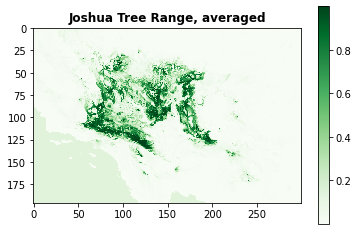

In [ ]:
from pylab import plt
# define spatial plotter
def plotit(x, title, cmap="Blues"):
    plt.imshow(x, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.title(title, fontweight = 'bold')

import rasterio
distr_rf = rasterio.open("outputs/rf-images/probability_1.0.tif").read(1)
distr_et = rasterio.open("outputs/et-images/probability_1.0.tif").read(1)
distr_xgb =  rasterio.open("outputs/xgb-images/probability_1.0.tif").read(1)
distr_lgbm =  rasterio.open("outputs/lgbm-images/probability_1.0.tif").read(1)
distr_averaged = (distr_rf + distr_et + distr_xgb + distr_lgbm)/4  

plotit(distr_averaged, "Joshua Tree Range, averaged", cmap="Greens")

Lastly, let's zoom in to Joshua Tree National Park and inspect the suitability there.

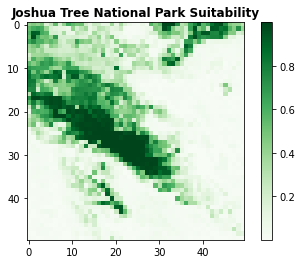

In [ ]:
plotit(distr_averaged[100:150, 100:150], "Joshua Tree National Park Suitability", cmap="Greens")

Train ML Classifiers